LSTM, 用前n天的最高价来预测当天的最高价

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('sh.csv')

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(['datetime'])

In [4]:
df.head()

,code,open,close,high,low,vol,amount,p_change
datetime,,,,,,,,
2005-01-04,300,994.76,982.79,994.76,980.65,74128.0,4.431976e+09,NaN
2005-01-05,300,981.57,992.56,997.32,979.87,71191.0,4.529207e+09,0.99
2005-01-06,300,993.33,983.17,993.78,980.33,62880.0,3.921015e+09,-0.95
2005-01-07,300,983.04,983.95,995.71,979.81,72986.0,4.737468e+09,0.08
2005-01-10,300,983.76,993.87,993.95,979.78,57916.0,3.762931e+09,1.01


In [5]:
def getData(df, column, train_end=-300, days_before=30, return_all=True, generate_index=False):
    series = df[column].copy()    #选取输入的列
    train_series, test_series = series[:train_end], series[train_end - days_before:] #训练集截止于倒数第300天
    
    train_data = pd.DataFrame()  #新空dataframe
    
    for i in range(days_before):    
        train_data['c%d' % i] = train_series.tolist()[i: -days_before + i]
        
    train_data['y'] = train_series.tolist()[days_before:]
    
    if generate_index:
        train_data.index = train_series.index[n:]
    if return_all:
        return train_data, series, df.index.tolist()
    
    return train_data

In [6]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = 1, hidden_size = 64, num_layers = 1, batch_first =True)
        self.out = nn.Sequential(nn.Linear(64, 1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)
        out = self.out(r_out[:, -1, :])
        
        return out

In [7]:
class TrainSet(Dataset):
    def __init__(self, data):
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()
        
    def __getitem__(self, index):
        return self.data[index], self.label[index]
    
    def __len__(self):
        return len(self.data)

In [8]:
LR = 0.0001
EPOCH = 1000
TRAIN_END = -300
DAYS_BEFORE = 100

C:\Users\ZSZ\Anaconda3\envs\pytorch\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


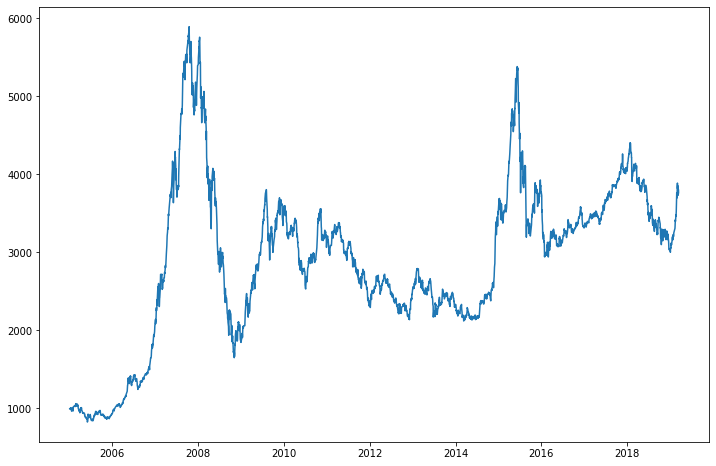

In [9]:
train_data, all_series, df_index = getData(df, 'high', days_before=DAYS_BEFORE, train_end=TRAIN_END)

all_series = np.array(all_series.tolist())

plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
plt.show()



In [10]:
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std = np.std(train_data_numpy)
train_data_numpy_n = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy_n)

train_set = TrainSet(train_data_tensor)
train_Loader = DataLoader(train_set, batch_size=10, shuffle=True)

In [11]:
model = LSTM()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for e in range(EPOCH):
    for tx, ty in train_Loader:
        
        tx = tx.cuda()
        ty = ty.cuda()
        
    output = model(torch.unsqueeze(tx, dim=2))
    loss = criterion(torch.squeeze(output), ty)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 100 == 0:
        print('epoch: {},loss: {}'.format(e, loss) )

torch.save(model, 'lstm.pkl')    

epoch: 0,loss: 1.3231804370880127
epoch: 100,loss: 0.7247072458267212
epoch: 200,loss: 0.5144063234329224
epoch: 300,loss: 0.17620864510536194
epoch: 400,loss: 0.08274830132722855
epoch: 500,loss: 0.029597848653793335
epoch: 600,loss: 0.01494657900184393
epoch: 700,loss: 0.010999678634107113
epoch: 800,loss: 0.032587043941020966
epoch: 900,loss: 0.016783036291599274


C:\Users\ZSZ\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


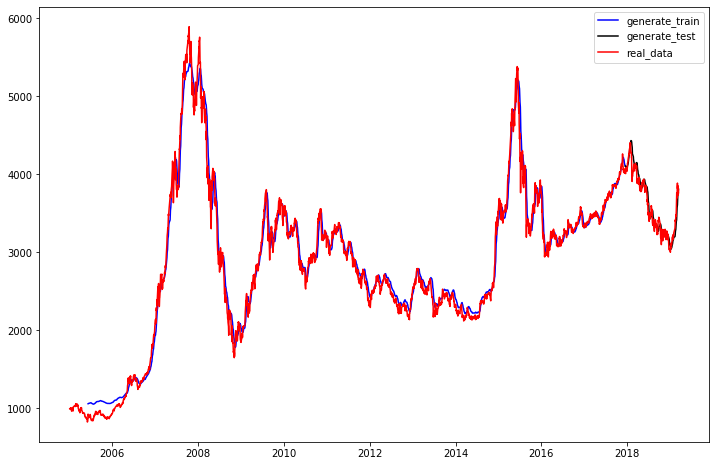

In [12]:

generate_data_train = []
generate_data_test = []

# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END

# 对所有的数据进行相同的归一化
all_series = (all_series - train_mean) / train_std
all_series = torch.Tensor(all_series)

for i in range(DAYS_BEFORE, len(all_series)):
    x = all_series[i - DAYS_BEFORE:i]
    # 将 x 填充到 (bs, ts, is) 中的 timesteps
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)
    
    if torch.cuda.is_available():
        x = x.cuda()

    y = model(x)
    
    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
        
plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series.clone().numpy()* train_std + train_mean, 'r', label='real_data')
plt.legend()
plt.show()

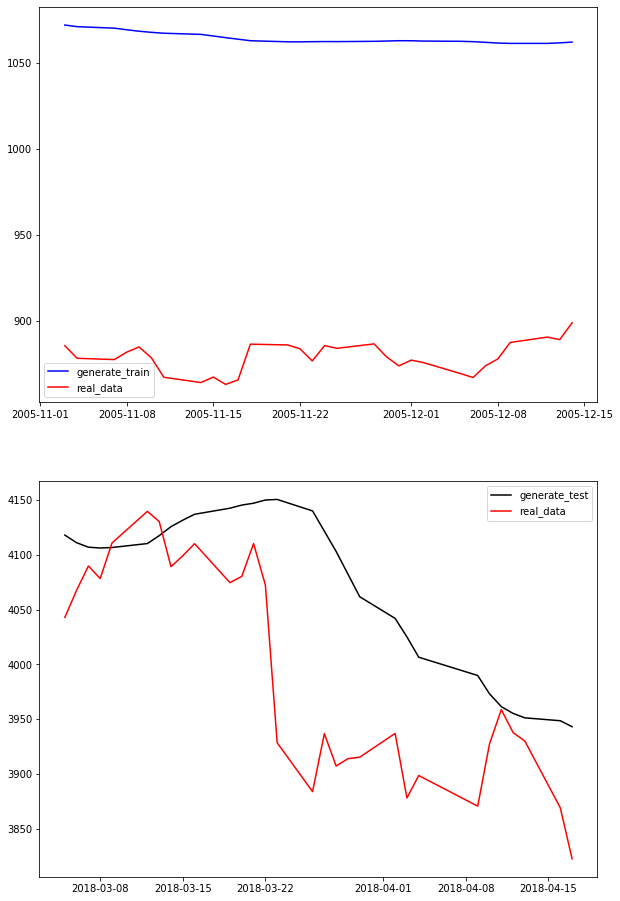

In [13]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], generate_data_test[50:80], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], (all_series.clone().numpy()* train_std + train_mean)[TRAIN_END + 50: TRAIN_END + 80], 'r', label='real_data')
plt.legend()

plt.show()